# Teaching a 'Large' Language Model to Perform Addition

We would like to pass to a model a string describing an addition such as "23+1=" and get the model to complete the string with the actual result "23+1=24"

The model will be built using a transformer network and trained with a next-token prediction objective, where it learns to predict the next symbol in a sequence given the previous ones.

In [1]:
# import the libraries we need
import torch
from torch import nn
from torch.nn import functional as F
import random
import math
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import zipfile
import shutil
from tqdm import tqdm

## step 1: construct a tokenizer

A tokenizer is a tool that breaks down raw text into smaller units (called tokens) that a language model can understand and process. 

In our addition task, the vocabulary is straightforward: it includes the **digits (0–9)**, the symbols **+** and **=**, as well as special tokens such as **[EOS]** (end of sequence) and **[PAD]** (padding). The padding token ensures that all queries have the same sequence length, which simplifies processing.

Our complete set of tokens is:  
`{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, +, =, [PAD], [EOS]}`  

We assign a unique number to each token and build a **tokenizer**—a class that converts a string of characters into a list of tokens.

In [2]:
# special token
pad_token="[PAD]"
eos_token="[EOS]"

In [3]:
class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"

    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])



Note that since our digits are 0–9, the token IDs for the other symbols follow sequentially:  
- `+` is assigned token ID **10**  
- `=` is assigned token ID **11**
- `[PAD]`is assigned token ID **12**
- `[EOS]`is assigned token ID **13**


In [4]:
tokenizer = character_level_tokenizer()

ntokens = tokenizer.ntokens
print(f'Number of tokens in the vocabulary: {ntokens}')

prompt = "12 + 42 = "
inputs = tokenizer.encode(prompt)
print(f'\nPrompt: {prompt}')
print(f'Input: {inputs}')
print(f'Input tokenized: {tokenizer.decode(inputs)}')


prompt_answer = "12 + 42 = 54"
inputs = tokenizer.encode(prompt_answer)
print(f'\nPrompt: {prompt_answer}')
print(f'Input: {inputs}')
print(f'Input tokenized: {tokenizer.decode(inputs)}')

Number of tokens in the vocabulary: 14

Prompt: 12 + 42 = 
Input: [1, 2, 10, 4, 2, 11]
Input tokenized: 12+42=

Prompt: 12 + 42 = 54
Input: [1, 2, 10, 4, 2, 11, 5, 4]
Input tokenized: 12+42=54


Now, we can create data for training our model, including both the **model input** (e.g., `100+205=`) and the **target output** (e.g., `305`).

In [5]:
#%% create a suite of queries to check the carry
def convert_datapoint(a_int,b_int):
    """
    returns a string containing two given numbers and their sum
    """
    sum_int = a_int + b_int
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

# build a series with a carry
a, b = 100, 205
data_series = []
for k in range(10):
    data_series.append(convert_datapoint(int(a+k),b))
print(data_series)

[('100+205=', '305'), ('101+205=', '306'), ('102+205=', '307'), ('103+205=', '308'), ('104+205=', '309'), ('105+205=', '310'), ('106+205=', '311'), ('107+205=', '312'), ('108+205=', '313'), ('109+205=', '314')]


## step 2: create a dataset for addition operations

We will constrain the numbers in our queries to have a maximum of **3 digits** (0–999). This gives approximately **1,000,000 possible queries**, with the largest result being **1,998** (999 + 999). 

> **Note:** `10 + 12` is considered a different query from `12 + 10` since they generate different input strings for the model.


In [ ]:
def sample_datapoint(number_digits = 3):
    """
    returns a string containing two random numbers with `number_digits` and their sum.
    """
    # TODO: let's sample some data points to train our model 
    # generate operand 1
    a_list = [random.randint(0, 9) for _ in range(number_digits)]
    a_int = int("".join([str(x) for x in a_list]))
    # generate operand 2
    b_list = [random.randint(0, 9) for _ in range(number_digits)]    
    b_int = int("".join([str(x) for x in b_list]))
    # compute ground-truth sum
    sum_int = a_int + b_int
    # setup datapoint
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

sample_datapoint(3)

('350+654=', '1004')

We can now define our data parameters and create a dataset with a given number of samples

In [ ]:
# dataset parameters
number_digits = 3
dataset_size = 50000
train_proportion = 0.8 # 80% training, 20% validation
train_size = int(train_proportion * dataset_size)
test_size = dataset_size - train_size

# TODO: generate a train and test set without overlaping using rejection sampling
# generate a training dataset 
data_train = [sample_datapoint(number_digits) for _ in range(train_size)]

# generate test dataset using rejection sampling to avoid overlaping between train and test datasets
data_test = []
while len(data_test) < test_size:
    sample = sample_datapoint(number_digits)
    if not(sample in data_train):
        data_test.append(sample)
    
# print some outputs    
print(len(data_train),len(data_test))
print(data_train[:4], data_test[:4])

40000 10000
[('171+276=', '447'), ('896+311=', '1207'), ('629+358=', '987'), ('168+993=', '1161')] [('697+259=', '956'), ('682+484=', '1166'), ('210+531=', '741'), ('699+854=', '1553')]


## step 3: positional encoding

LLMs work with sequence data — in our case, sequences of tokens. However, transformers process all tokens in a sequence **in parallel**, so they don’t inherently know the **order** of words. Positional encoding is a technique that **adds information about the position of each token**, allowing the model to understand the sequence order.


#### How it works
1. Each token is converted into an **embedding vector** that represents its meaning.  
2. A **positional encoding vector** is added to each token embedding. This vector encodes the token’s position in the sequence.  
3. The resulting vectors carry both **semantic information** (from the token embedding) and **positional information** (from the positional encoding).

#### Common Approach
The original Transformer paper uses **sinusoidal functions** to encode positions:

$$
\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right), \quad
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
$$

- `pos` = position in the sequence  
- `i` = dimension index  
- `d` = embedding size  

This ensures each position in the sequence has a **unique pattern**, helping the model learn relative positions between tokens.



In [ ]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # TODO: compute positional ecoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # log exp trick for stability
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pytorch buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        # TODO: apply positional encoding
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Let's visualize the position encoding in 2 dimensions

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


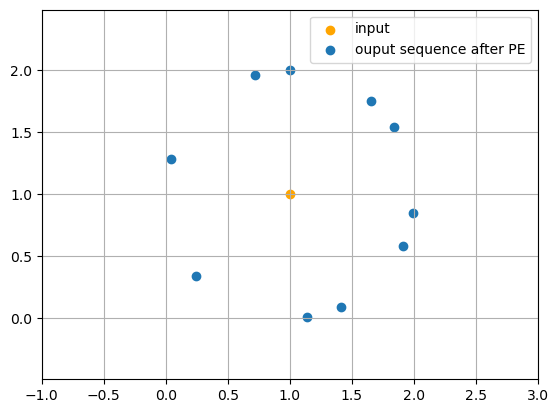

In [9]:
PE = PositionalEncoding(d_model=2,dropout=0)
# create tensor with the same vector
x = torch.ones((10,1,2)) #[seq lenght x batch x dim]
# apply PE and check out the result
y = PE(x)

# plot
plt.scatter(1,1,c='orange',label='input')
plt.scatter(y[:,0,0],y[:,0,1],label='ouput sequence after PE')
plt.axis('equal')
plt.xlim((-1,3))
plt.ylim((-1,3))
plt.grid('on')
plt.legend()

## step 4: build the model

We will use a simpler Transformer network with **causal attention** (each next token can only rely on previous tokens). The following diagram shows the flow of data through the Transformer model:

$$
\begin{align*}
\text{Input tokens} &\rightarrow \text{Embedding} \\
&\rightarrow \text{Positional Encoding} \\
&\rightarrow \text{Transformer Encoder (masked)} \\
&\rightarrow \text{Linear Decoder} \\
&\rightarrow \text{Log-softmax output}
\end{align*}
$$

- **Input tokens**: Sequence of token indices (e.g., digits and symbols for addition).  
- **Embedding**: Converts token indices to dense vectors with `ninp` dimension.  
- **Positional Encoding**: Adds information about token positions.  
- **Transformer Encoder (masked)**: Applies self-attention only to previous tokens (causal).  
- **Linear Decoder**: Projects encoder outputs to vocabulary size.  
- **Log-softmax output**: Produces log-probabilities for next-token prediction.





In [ ]:
class CustomEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None, **kwargs):
        # Capture the attention weights by setting need_weights=True
        src2, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False  # (B, num_heads, S, S)
        )
        self.attn_weights = attn_weights
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = CustomEncoderLayer(ninp, nhead, nhid, 0.1)
        self.encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(ninp, ntoken)
        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        # TODO: generate a LxL casual attention mask
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src):        
        mask = self._generate_square_subsequent_mask(len(src)).to(src.device)
        # TODO: Inference of the model
        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output_enc = self.encoder(src, mask=mask)
        output_dec = self.decoder(output_enc)
        # Gather attention maps from all encoder layers
        attention_maps = [layer.attn_weights for layer in self.encoder.layers]
        return F.log_softmax(output_dec, dim=-1), output_enc, attention_maps


In [11]:
# instantiate the model and check it
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 6)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# size of the model
model.train() 
Nparams = sum(p.numel() for p in model.parameters())
Nparams_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'parameters: {Nparams}, trainable parameters: {Nparams_train}')

TransformerModel(
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x CustomEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
)
cuda
parameters: 502414, trainable parameters: 502414


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Step 5: Handling functions 

### Autorregressive token generator 

Our transformer so far takes a sequence of tokens as input and predicts the probability (or log-probability) of the next token in our vocabulary. To generate new sequences, we use an **autoregressive generation function**: it takes a sequence of input tokens (`prompts`) and produces `new_tokens` additional tokens **one by one**, always feeding back the previously generated tokens into the model to predict the next one. The result is the full sequence: original prompt plus the newly generated tokens.


In [ ]:
def generate(model, prompts, new_tokens = 5):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    for _ in range(new_tokens):
        # TODO: let's implement autoregressive prdiction. The model needs to predict the next toke from the previous in sequence.
        output, _, _ = model(input_tensor) # (length_prompts, batch_size, ntokens)
        last_output = output[-1,:,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
        input_tensor = torch.cat((input_tensor, token), 0)
    return input_tensor

In [13]:
# try to generate 5 new tokens
model.eval()
prompt = "2+3="
print(f'prompt: {prompt}')
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
print(f'prompt encoded: {prompt_tensor}')
output = generate(model, prompt_tensor, new_tokens = 5).view((1,-1))
print(f'output: {output}')
print(f'output decoded: {tokenizer.decode(output.tolist()[0])}')

prompt: 2+3=
prompt encoded: tensor([[ 2],
        [10],
        [ 3],
        [11]])
output: tensor([[ 2, 10,  3, 11,  3,  1,  3,  3,  3]], device='cuda:0')
output decoded: 2+3=31333


### Sequence Padding and Masking

Transformers process batches of sequences (prompts) in parallel. However, these sequences can have different lengths, which makes it difficult to use them directly, since most neural network backbones expect tensors with consistent shapes.  

To efficiently train on multiple examples at once, we use **padding** and **masking**:

- **Padding**: `<pad>` tokens are added as placeholders so that shorter sequences “fit” into the same tensor size as longer ones.  
- **Masking**: During training, we provide an **attention mask** to tell the model to ignore padded positions, so it does not accidentally learn from them.  
- **Prompts**: Padding ensures that all input sequences align properly when batching.  
- **Answers**: We insert an `<eos>` (end-of-sequence) token so the model knows where the answer ends, then pad to equalize sequence lengths.  

In [14]:
def pad(token_list, type_list = "prompts"):
    assert type_list in ['prompts', 'answers']
    # pad so that all the prompt have the same number of tokens
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x) # padding + sequence
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x))) # sequence + eos + padding                    
    return out, max_length

In [15]:
prompts = [tokenizer.encode("1+0="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("1"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
for p in prompts: 
    print(f'Prompts : {tokenizer.decode(p)}')
for p in answers: 
    print(f'Answers : {tokenizer.decode(p)}')
for p in padded_prompts: 
    print(f'Prompts padded: {tokenizer.decode(p)}')
for p in padded_answers:
    print(f'Answers padded: {tokenizer.decode(p)}')

Prompts : 1+0=
Prompts : 21+35=
Answers : 1
Answers : 56
Prompts padded: [PAD][PAD]1+0=
Prompts padded: 21+35=
Answers padded: 1[EOS][PAD]
Answers padded: 56[EOS]


### Batchfy Dataset

We need a function to draw a batch from the datasets since we don't use pytorch dataloader

In [16]:
batch_size=100
def get_batch(data, i):
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

# create a batch for training from position 243 until 243 + batchsie
X, Y, length_prompts, length_answers = get_batch(data_train, 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([8, 100]), torch.Size([5, 100]), 8, 4)

As a sanity check, run the model on a series of 10 consecutive queries to observe how it works.
> **NOTE:** The results should be **nonsensical**, since the model still has **random weights**


In [17]:
model.eval()
print(' Testing the model on a series of numbers to check the carry\n')
for i in range(len(data_series)):
    prompt, answers = data_series[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    # output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    output = generate(model, prompt_tensor, 5).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

 Testing the model on a series of numbers to check the carry

100+205=33333	 actual result: 305
101+205=33333	 actual result: 306
102+205=33333	 actual result: 307
103+205=33333	 actual result: 308
104+205=33333	 actual result: 309
105+205=33333	 actual result: 310
106+205=33333	 actual result: 311
107+205=33333	 actual result: 312
108+205=33333	 actual result: 313
109+205=33333	 actual result: 314


## Step 6: Evaluating Model Accuracy

To monitor training, we need a way to measure how well the model predicts. The simplest metric is **accuracy**, which can be computed at either the digit level or the sequence level.  

**Digit-level accuracy** measures the percentage of correctly predicted tokens (digits):  

$$
\text{Accuracy}_{\text{digit}} = \frac{\text{Number of correct tokens}}{\text{Total number of tokens}}
$$  

This tells us how often the model predicts each digit correctly.  

**Sequence-level accuracy** measures the percentage of completely correct additions:  

$$
\text{Accuracy}_{\text{sequence}} = \frac{\text{Number of correct sequences}}{\text{Total number of sequences}}
$$  

In addition, we can compare the predicted answers (as integers) with the true answers. A **scatter plot** of predictions vs. ground truth provides a visual check — ideally, all points should fall along the diagonal line.

In [ ]:
def evaluate(data):
    # compute how many digits are correctly predicted
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct_digit, total_digit, correct, total = 0., 0., 0. ,0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data) - 1, batch_size)):            
            prompts, target_answers, length_prompts, length_answers = get_batch(data, i)            
            prompts         = prompts.to(device) # (length_prompts, batch_size)
            target_answers  = target_answers.to(device) # (length_answers + 1, batch_size)
            
            output          = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens  = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens

            # compare predictions
            target_mask_pad = target_answers != tokenizer.token_to_id[pad_token]
            equality_test = answers_tokens == target_answers            
        
            # digit accuracy computation
            # TODO: compute digit accuracy
            correct_digit += torch.logical_and(target_mask_pad, equality_test).sum().item()
            total_digit += target_mask_pad.sum().item()
        
            # full sequence accuracy computation
            # TODO: Compute sequence accuracy
            correct += torch.all(torch.logical_or(~target_mask_pad, equality_test), axis=0).float().sum().item()
            total += target_answers.shape[-1]
        
        # TODO: compute digit and sequence accuracy
        digit_accuracy = correct_digit / total_digit
        seq_accuracy = correct / total
        
    return digit_accuracy, seq_accuracy

def errorTest(data):
    # convert model answer and target to integers
    # Turn on evaluation mode disables dropout.
    model.eval()
    num_ans = []
    num_tgt = []
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data) - 1, batch_size)):            
            # predict on a batch
            prompts, target_answers, length_prompts, length_answers = get_batch(data, i)            
            prompts         = prompts.to(device) # (length_prompts, batch_size)
            target_answers  = target_answers.to(device) # (length_answers + 1, batch_size)
            output          = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens  = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            
            # compute the numerical error between tgt and answer
            n_d,n_b = answers_tokens.shape
            for idx,b in enumerate(range(n_b)):
                # go through the batch
                ans         = tokenizer.decode(answers_tokens[:,b].tolist())
                tgt         = tokenizer.decode(target_answers[:,b].tolist())
                
                ans_cleaned = ans.replace('[EOS]', '').replace('[PAD]', '')
                tgt_cleaned = tgt.replace('[EOS]', '').replace('[PAD]', '')
                
                num_ans.append(int(ans_cleaned) if ans_cleaned != '' else 0)
                num_tgt.append(int(tgt_cleaned) if ans_cleaned != '' else 0)
    num_ans = torch.tensor(num_ans)
    num_tgt = torch.tensor(num_tgt)
    return num_ans,num_tgt

test_digit_accuracy, test_seq_accuracy = evaluate(data_test)
test_digit_accuracy, test_seq_accuracy

(0.08311063602351683, 0.0)

## Step 7: Train the model

We now have everything we need to train our large language model to perform addition. 

cuda
-----------------------------------------------------------------------------------------
| initialisation | test digit accuracy 0.174 | test seq accuracy 0.000
-----------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 177.43it/s]


Epoch   1 (17.47s), test digit accuracy:0.492, test seq accuracy:0.005, train digit accuracy:0.494, train seq accuracy:0.004, loss: 1.44


100%|██████████| 100/100 [00:00<00:00, 181.47it/s]


Epoch   2 (17.42s), test digit accuracy:0.521, test seq accuracy:0.005, train digit accuracy:0.524, train seq accuracy:0.005, loss: 1.14


100%|██████████| 100/100 [00:00<00:00, 182.19it/s]


Epoch   3 (17.40s), test digit accuracy:0.551, test seq accuracy:0.008, train digit accuracy:0.553, train seq accuracy:0.007, loss: 1.08


100%|██████████| 100/100 [00:00<00:00, 178.56it/s]


Epoch   4 (17.42s), test digit accuracy:0.547, test seq accuracy:0.006, train digit accuracy:0.549, train seq accuracy:0.006, loss: 1.05


100%|██████████| 100/100 [00:00<00:00, 178.30it/s]


Epoch   5 (17.68s), test digit accuracy:0.584, test seq accuracy:0.017, train digit accuracy:0.586, train seq accuracy:0.017, loss: 1.03


100%|██████████| 100/100 [00:00<00:00, 181.09it/s]


Epoch   6 (17.60s), test digit accuracy:0.662, test seq accuracy:0.056, train digit accuracy:0.666, train seq accuracy:0.061, loss:0.933


100%|██████████| 100/100 [00:00<00:00, 181.74it/s]


Epoch   7 (17.41s), test digit accuracy:0.732, test seq accuracy:0.055, train digit accuracy:0.737, train seq accuracy:0.061, loss:0.787


100%|██████████| 100/100 [00:00<00:00, 181.74it/s]


Epoch   8 (17.39s), test digit accuracy:0.757, test seq accuracy:0.075, train digit accuracy:0.760, train seq accuracy:0.077, loss:0.719


100%|██████████| 100/100 [00:00<00:00, 181.28it/s]


Epoch   9 (17.39s), test digit accuracy:0.761, test seq accuracy:0.095, train digit accuracy:0.762, train seq accuracy:0.095, loss:0.681


100%|██████████| 100/100 [00:00<00:00, 181.60it/s]


Epoch  10 (17.38s), test digit accuracy:0.785, test seq accuracy:0.118, train digit accuracy:0.788, train seq accuracy:0.122, loss:0.641


100%|██████████| 100/100 [00:00<00:00, 181.36it/s]


Epoch  11 (17.39s), test digit accuracy:0.806, test seq accuracy:0.179, train digit accuracy:0.809, train seq accuracy:0.189, loss:0.621


100%|██████████| 100/100 [00:00<00:00, 181.48it/s]


Epoch  12 (17.39s), test digit accuracy:0.819, test seq accuracy:0.225, train digit accuracy:0.821, train seq accuracy:0.233, loss:0.561


100%|██████████| 100/100 [00:00<00:00, 181.45it/s]


Epoch  13 (17.40s), test digit accuracy:0.848, test seq accuracy:0.346, train digit accuracy:0.850, train seq accuracy:0.350, loss:0.481


100%|██████████| 100/100 [00:00<00:00, 181.10it/s]


Epoch  14 (17.42s), test digit accuracy:0.874, test seq accuracy:0.457, train digit accuracy:0.877, train seq accuracy:0.470, loss:0.439


100%|██████████| 100/100 [00:00<00:00, 181.34it/s]


Epoch  15 (17.42s), test digit accuracy:0.910, test seq accuracy:0.617, train digit accuracy:0.911, train seq accuracy:0.619, loss:0.388


100%|██████████| 100/100 [00:00<00:00, 181.38it/s]


Epoch  16 (17.41s), test digit accuracy:0.980, test seq accuracy:0.923, train digit accuracy:0.982, train seq accuracy:0.927, loss:  0.3


100%|██████████| 100/100 [00:00<00:00, 178.32it/s]


Epoch  17 (17.41s), test digit accuracy:0.987, test seq accuracy:0.951, train digit accuracy:0.988, train seq accuracy:0.954, loss:0.233


100%|██████████| 100/100 [00:00<00:00, 181.47it/s]


Epoch  18 (17.40s), test digit accuracy:0.986, test seq accuracy:0.948, train digit accuracy:0.987, train seq accuracy:0.950, loss:0.221


100%|██████████| 100/100 [00:00<00:00, 181.32it/s]


Epoch  19 (17.41s), test digit accuracy:0.984, test seq accuracy:0.936, train digit accuracy:0.984, train seq accuracy:0.936, loss: 0.19


100%|██████████| 100/100 [00:00<00:00, 181.52it/s]


Epoch  20 (17.41s), test digit accuracy:0.994, test seq accuracy:0.981, train digit accuracy:0.995, train seq accuracy:0.982, loss: 0.17


100%|██████████| 100/100 [00:00<00:00, 181.04it/s]


Epoch  21 (17.42s), test digit accuracy:0.991, test seq accuracy:0.970, train digit accuracy:0.993, train seq accuracy:0.975, loss:0.157


100%|██████████| 100/100 [00:00<00:00, 181.30it/s]


Epoch  22 (17.43s), test digit accuracy:0.994, test seq accuracy:0.983, train digit accuracy:0.995, train seq accuracy:0.984, loss:0.146


100%|██████████| 100/100 [00:00<00:00, 181.43it/s]


Epoch  23 (17.42s), test digit accuracy:0.993, test seq accuracy:0.976, train digit accuracy:0.994, train seq accuracy:0.981, loss:0.142


100%|██████████| 100/100 [00:00<00:00, 181.50it/s]


Epoch  24 (17.40s), test digit accuracy:0.995, test seq accuracy:0.986, train digit accuracy:0.996, train seq accuracy:0.988, loss:0.142


100%|██████████| 100/100 [00:00<00:00, 181.99it/s]


Epoch  25 (17.38s), test digit accuracy:0.995, test seq accuracy:0.984, train digit accuracy:0.996, train seq accuracy:0.987, loss:0.125


100%|██████████| 100/100 [00:00<00:00, 176.37it/s]


Epoch  26 (17.37s), test digit accuracy:0.995, test seq accuracy:0.983, train digit accuracy:0.996, train seq accuracy:0.986, loss:0.125


100%|██████████| 100/100 [00:00<00:00, 181.39it/s]


Epoch  27 (17.36s), test digit accuracy:0.996, test seq accuracy:0.988, train digit accuracy:0.997, train seq accuracy:0.990, loss:0.112


100%|██████████| 100/100 [00:00<00:00, 181.95it/s]


Epoch  28 (17.38s), test digit accuracy:0.996, test seq accuracy:0.986, train digit accuracy:0.997, train seq accuracy:0.988, loss:0.104


100%|██████████| 100/100 [00:00<00:00, 181.93it/s]


Epoch  29 (17.39s), test digit accuracy:0.996, test seq accuracy:0.988, train digit accuracy:0.997, train seq accuracy:0.991, loss:0.112


100%|██████████| 100/100 [00:00<00:00, 181.99it/s]


Epoch  30 (17.37s), test digit accuracy:0.996, test seq accuracy:0.988, train digit accuracy:0.997, train seq accuracy:0.991, loss:0.103
Total training time: 8.71 min



<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

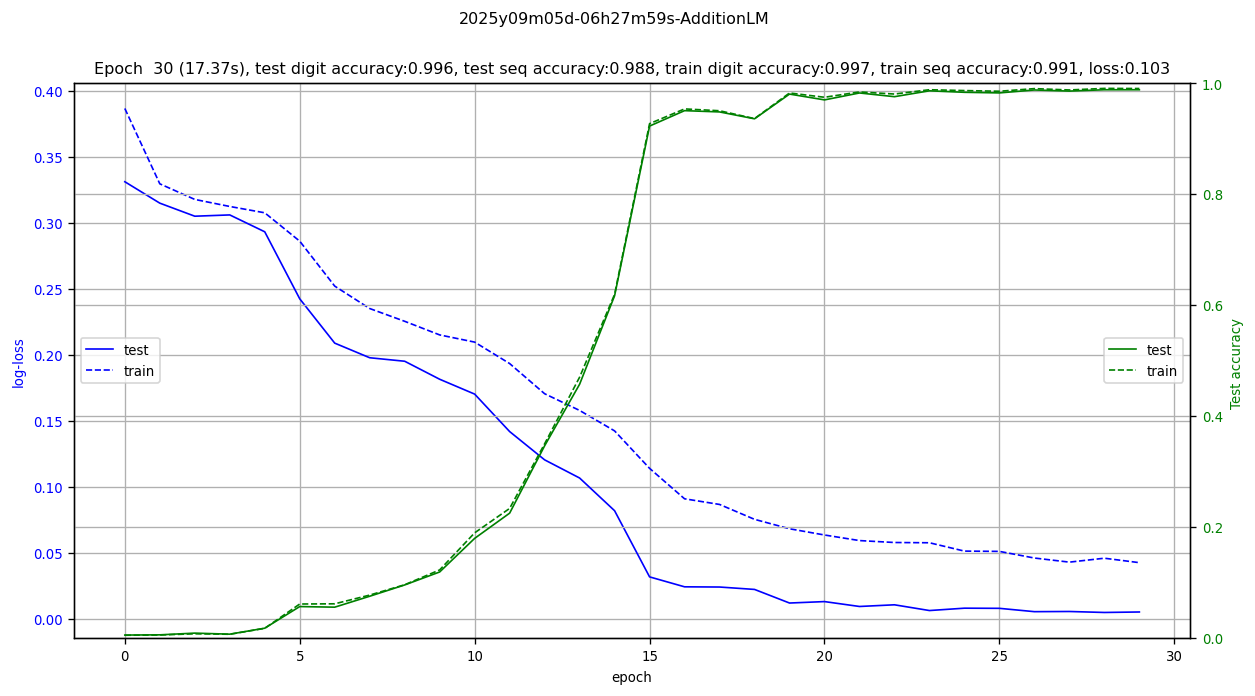

In [ ]:
learning_rate = 1e-3
epochs = 30
batch_size = 100
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# train step
def train_epoch(epoch):
    model.train()
    

    total_loss = 0.
    n_batch = 0
    iterable = range(0, len(data_train) - 1, batch_size)
    for batch, i in tqdm(enumerate(iterable),total=len(iterable),colour='GREEN'):
        n_batch += 1
        prompts, target_answers, length_prompts, length_answers = get_batch(data_train, i)    
        # TODO: let's code next token prediction            
        prompts         = prompts.to(device) # (length_prompts, batch_size)
        target_answers  = target_answers.to(device) # (length_answers, batch_size)        
        input_tensor    = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        
        optimizer.zero_grad()
        
        output, output_enc, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)
        output_answers  = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers  = target_answers.view(-1)
        
        if f_useCrossEntropy:
            loss            = F.cross_entropy(output_answers, target_answers)
        else:
            target_one_hot  = F.one_hot(target_answers, num_classes = output_answers.size(1)).to(output_answers.dtype)
            loss            = 100*F.mse_loss(output_answers, target_one_hot)
            
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

   
    total_loss        /= n_batch
    train_digit_accuracy, train_seq_accuracy   = evaluate(data_train)
    
    return total_loss, train_digit_accuracy, train_seq_accuracy
    
# test step
def test_epoch(epoch=1):
    model.eval()

    total_loss = 0.
    n_batch = 0
    iterable = range(0, len(data_test) - 1, batch_size)
    for batch, i in tqdm(enumerate(iterable),total=len(iterable)):
        n_batch += 1
        prompts, target_answers, length_prompts, length_answers = get_batch(data_test, i)
        prompts         = prompts.to(device) # (length_prompts, batch_size)
        target_answers  = target_answers.to(device) # (length_answers, batch_size)
        input_tensor    = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        
        with torch.no_grad():        
            output, output_enc, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)
        output_answers  = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers  = target_answers.view(-1)
        
        if f_useCrossEntropy:
            loss            = F.cross_entropy(output_answers, target_answers)
        else:
            target_one_hot  = F.one_hot(target_answers, num_classes = output_answers.size(1)).to(output_answers.dtype)
            loss            = 100*F.mse_loss(output_answers, target_one_hot)
            
        total_loss += loss.item()

    total_loss        /= n_batch
    test_digit_accuracy, test_seq_accuracy  = evaluate(data_test)
    
    return total_loss, test_digit_accuracy, test_seq_accuracy

# actual loop
def train():
    train_losses4disp   = []
    test_losses4disp    = []
    test_digit_accuracy4disp  = []
    train_digit_accuracy4disp = []
    test_seq_accuracy4disp  = []
    train_seq_accuracy4disp = []
    
    AUAC_test   = 0
    AUAC_train  = 0
    best_test_accuracy = None
    test_digit_accuracy, test_seq_accuracy = evaluate(data_test)
    print('-' * 89)
    print('| initialisation | test digit accuracy {:5.3f} | test seq accuracy {:5.3f}'.format(test_digit_accuracy, test_seq_accuracy))
    print('-' * 89)
    training_start_time = time.time()
    for epoch in range(1, epochs+1):
        epoch_start_time            = time.time()
        train_loss,train_digit_accuracy,train_seq_accuracy   = train_epoch(epoch)
        test_loss,test_digit_accuracy,test_seq_accuracy     = test_epoch(epoch)
        
        
        train_losses4disp.append(train_loss)
        test_losses4disp.append(test_loss)
        train_digit_accuracy4disp.append(train_digit_accuracy)
        test_digit_accuracy4disp.append(test_digit_accuracy)
        train_seq_accuracy4disp.append(train_seq_accuracy)
        test_seq_accuracy4disp.append(test_seq_accuracy)
        
        
        # print('-' * 50)
        str_epoch = 'Epoch {:3d} ({:5.2f}s), test digit accuracy:{:5.3f}, test seq accuracy:{:5.3f}, train digit accuracy:{:5.3f}, train seq accuracy:{:5.3f}, loss:{:5.3}'.format(
            epoch, (time.time() - epoch_start_time), test_digit_accuracy, test_seq_accuracy, train_digit_accuracy, train_seq_accuracy, train_loss)
        print(str_epoch)
    
    total_training_time = (time.time()-training_start_time)/(60)
    str_time = f'Total training time: {total_training_time:.2f} min\n'
    print(str_time)
    return np.array(train_losses4disp), np.array(test_losses4disp),\
           np.array(test_digit_accuracy4disp), np.array(train_digit_accuracy4disp),\
            np.array(test_seq_accuracy4disp), np.array(train_seq_accuracy4disp),\
           (str_epoch,str_time)    

# load a pretrained model if given
pretrained = None
if pretrained is not None:
  model.load_state_dict(torch.load(pretrained, map_location=torch.device(device),weights_only=True))  


f_train = True
f_useCrossEntropy = True

datename  = datetime.datetime.now().strftime('%Yy%mm%dd-%Hh%Mm%Ss')
genName   = datename + "-AdditionLM" 

if f_train:
    train_losses4disp, test_losses4disp, test_digit_accuracy4disp, train_digit_accuracy4disp, test_seq_accuracy4disp, train_seq_accuracy4disp, str_results = train()
    str_epoch,str_time = str_results
    torch.save(model.state_dict(), genName + ".pkl")

# training/validation plots
f   = plt.figure(figsize=(12,6),dpi=120) # A4 format, square
plt.rc('font',size= 8)
#%%   losses plot
ax  = f.add_subplot(1,1,1)
ax.plot( np.log10(1.+test_losses4disp),color='b',label='test',linewidth=1)
ax.plot( np.log10(1.+train_losses4disp),color='b',linestyle='--',label='train',linewidth=1)
ax.set_xlabel("epoch")
ax.set_ylabel("log-loss",color='b')
ax.tick_params(axis='y', labelcolor='b')
ax.set_title(str_epoch)
ax.legend(loc='center left')
plt.grid()

#%%   accuracy plot
ax2 = ax.twinx()
ax2.plot( test_seq_accuracy4disp ,color='green',label='test',linewidth=1)
ax2.plot( train_seq_accuracy4disp ,color='green',linestyle='--',label='train',linewidth=1)
ax2.set_xlabel("epoch")
ax2.set_ylabel("Test accuracy ",color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc = 'center right')
ax2.set_ylim((0,1)) 
plt.grid()

f.suptitle(genName)
plt.tight_layout



### Let's check the performance

Test the trained model on a few examples.

In [27]:
# in case you do not want to train
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.load_state_dict(torch.load('pretrained-AdditionLM.pkl'))

cuda


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


<All keys matched successfully>

In [28]:
model.eval()
print(' Testing the model on a few examples\n')
for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    # output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    output = generate(model, prompt_tensor, 5).view((1,-1))
    pred_answer = output.tolist()[0]; pred_answer = pred_answer[pred_answer.index(11)+1:]
    pred_answer = int(''.join([str(d) for d in pred_answer if 0 <= d <= 9]))
    is_correct = "C " if int(answers) == pred_answer  else "W "
    str_result = is_correct + tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers
    print(str_result)



print('\n Testing the model on a series of numbers to check the carry\n')
for i in range(len(data_series)):
    prompt, answers = data_series[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    # output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    output = generate(model, prompt_tensor, 5).view((1,-1))
    pred_answer = output.tolist()[0]; pred_answer = pred_answer[pred_answer.index(11)+1:]
    pred_answer = int(''.join([str(d) for d in pred_answer if 0 <= d <= 9]))
    is_correct = "C " if int(answers) == pred_answer  else "W "
    str_result = is_correct + tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers
    print(str_result)

 Testing the model on a few examples

C 697+259=956[EOS][PAD]	 actual result: 956
C 682+484=1166[EOS]	 actual result: 1166
C 210+531=741[EOS][PAD]	 actual result: 741
C 699+854=1553[EOS]	 actual result: 1553
W 54+85=1405[EOS]	 actual result: 139
C 223+518=741[EOS][PAD]	 actual result: 741
C 131+310=441[EOS][PAD]	 actual result: 441
C 993+744=1737[EOS]	 actual result: 1737
W 13+95=680[EOS][PAD]	 actual result: 108
C 159+327=486[EOS][PAD]	 actual result: 486
W 570+4=10010	 actual result: 574
C 986+436=1422[EOS]	 actual result: 1422
C 171+709=880[EOS][PAD]	 actual result: 880
W 10+620=703[EOS][PAD]	 actual result: 630
C 706+267=973[EOS][PAD]	 actual result: 973
W 78+389=11185	 actual result: 467
C 909+123=1032[EOS]	 actual result: 1032
C 107+298=405[EOS][PAD]	 actual result: 405
C 974+128=1102[EOS]	 actual result: 1102
C 612+585=1197[EOS]	 actual result: 1197

 Testing the model on a series of numbers to check the carry

C 100+205=305[EOS][PAD]	 actual result: 305
C 101+205=306[EOS][PAD]	

Let's visualise some plots

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

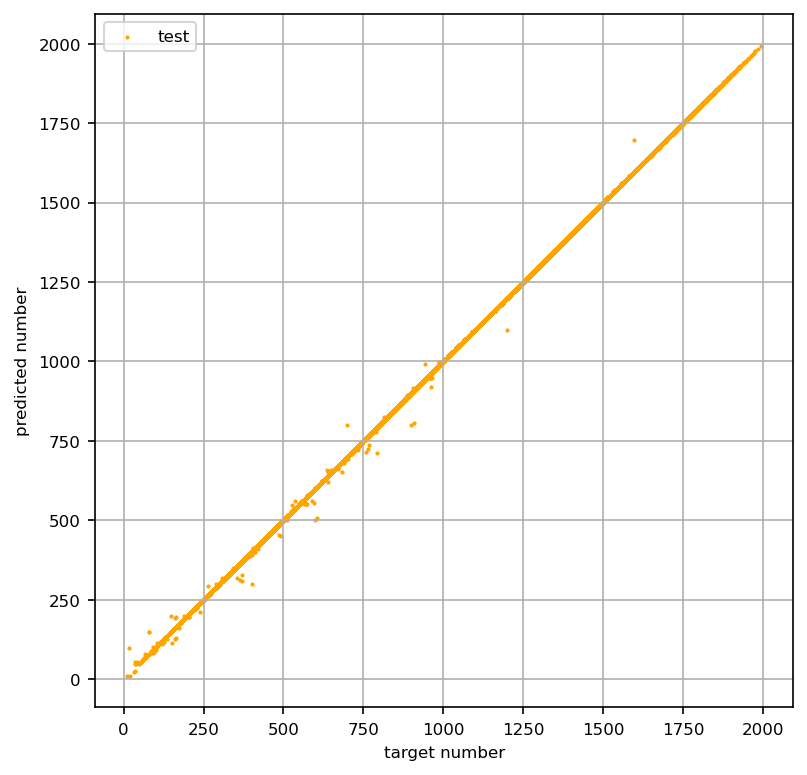

In [29]:
#%% plot of error

f   = plt.figure(figsize=(6,6),dpi=150) # A4 format, square
plt.rc('font',size= 8)

#%%   scatter plot
num_ans_test,num_tgt_test = errorTest(data_test)

ax  = f.add_subplot(1,1,1)
ax.scatter( num_tgt_test, num_ans_test,s=1,c='orange',label='test')
# ax.scatter( num_tgt_train, num_ans_train,s=1,c='green',label='train')
ax.set_xlabel("target number")
ax.set_ylabel("predicted number")
ax.legend()
plt.grid()
plt.tight_layout

### Visualizing Attention Maps

We can also visualize the attention maps of our model at each prediction step. This is not straightforward, since the model has multiple layers with multiple attention heads. However, these visualizations can sometimes reveal which inputs the model attends to at each step. Let’s explore a few examples.

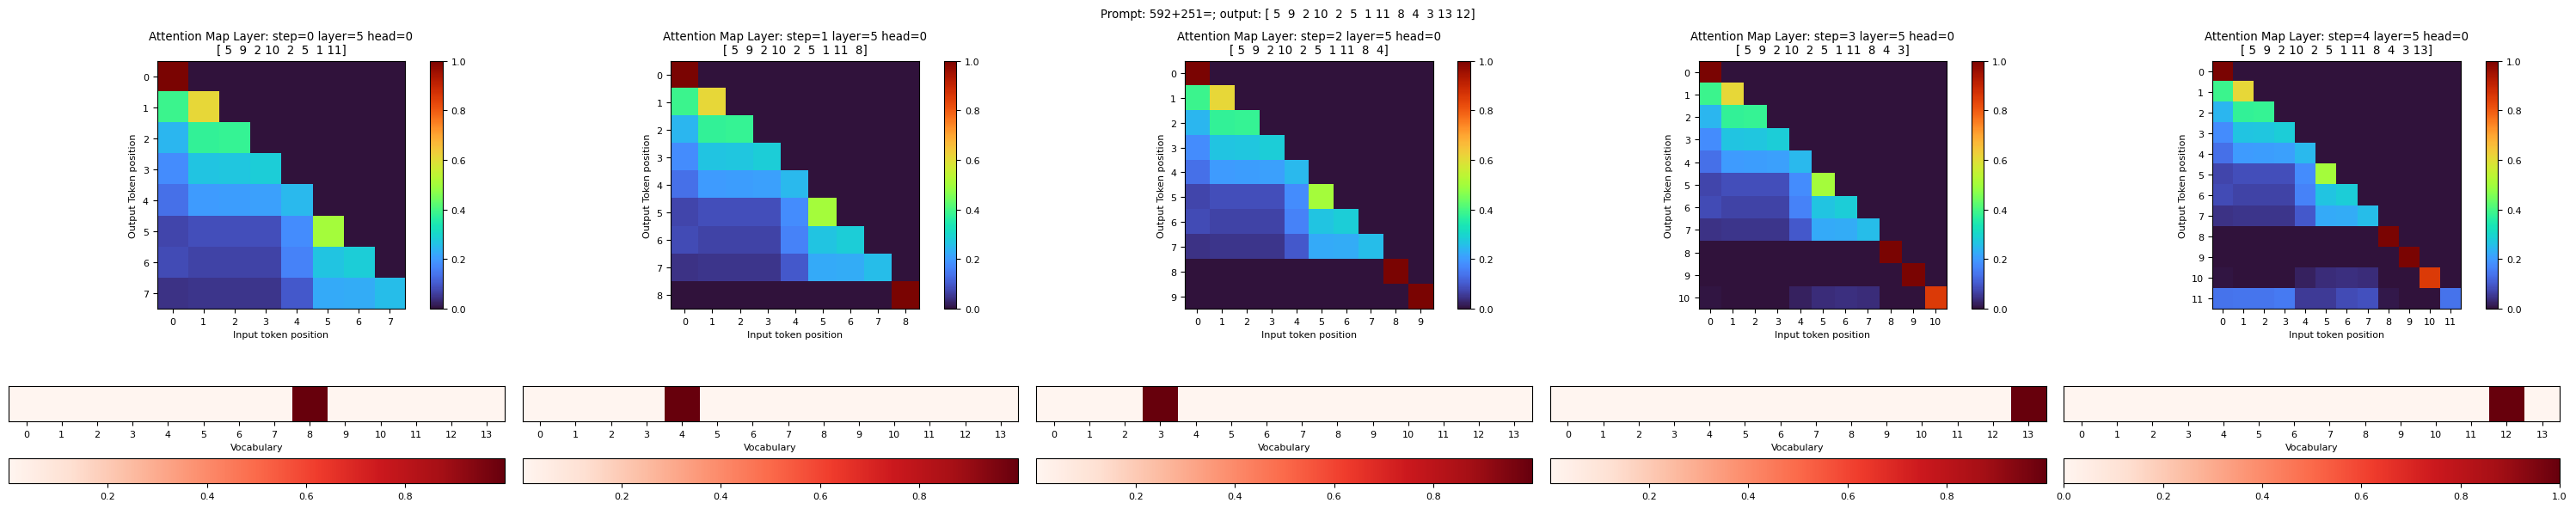

In [24]:
model.eval()
layer, attn_head = 5, 0       # layer to visualize
prompt, answers = ("592+251=", "843") # prompt and answer
input_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1)).to(device)
attn_maps_list, vocab_pred = [], []
for step in range(5):
    output, _, attention_maps = model(input_tensor)  # forward pass output is (length_prompts + length_answers, batch_size, ntokens)    
    # plot attention map for current input [layer][batch, head]   
    attn_maps_list.append(attention_maps[layer][0, attn_head].detach().cpu().numpy())    
    # get predicted next token from last time step
    last_output = output[-1, :, :]  # shape: (batch_size, vocab_size)   
    vocab_pred.append(torch.exp(last_output).detach().cpu().numpy().ravel())
    token = torch.argmax(last_output, -1).view(1, -1)  # shape: (1, batch_size)    
    # append predicted token to input tensor for next step
    input_tensor = torch.cat((input_tensor, token), dim=0)
input_tensor = input_tensor.detach().cpu().numpy().ravel()

fig, axes = plt.subplots(nrows=2, ncols=len(attn_maps_list), figsize=(6 * len(attn_maps_list), 6))
# import pdb; pdb.set_trace();
for s, (attn, vp) in enumerate(zip(attn_maps_list, vocab_pred)):
    # plot using your plotting code but passing axis
    axes[0,s].imshow(attn, cmap='turbo')
    axes[0,s].set_title(f"Attention Map Layer: step={s} layer={layer} head={attn_head}\n{input_tensor[:(-5 + s)]}")   
    axes[0,s].set_xlabel("Input token position"); axes[0,s].set_xticks(np.arange(attn.shape[0]));
    axes[0,s].set_ylabel("Output Token position"); axes[0,s].set_yticks(np.arange(attn.shape[0]));
    plt.colorbar(axes[0,s].images[0], ax=axes[0,s])
    
    axes[1,s].imshow(vp.reshape(1,-1), cmap='Reds')
    plt.colorbar(axes[1,s].images[0], ax=axes[1,s], orientation='horizontal')
    axes[1,s].set_xlabel("Vocabulary");
    axes[1,s].set_xticks(np.arange(len(vp)));
    axes[1,s].set_yticks([]);
    
plt.suptitle(f"Prompt: {prompt}; output: {input_tensor}")

plt.tight_layout()
plt.show()

## Future Improvements

We observed that most errors occur at the beginning of the predicted versus ground-truth graph (i.e., when small numbers are involved in the calculations). 

<Axes: xlabel='TGT', ylabel='Count'>

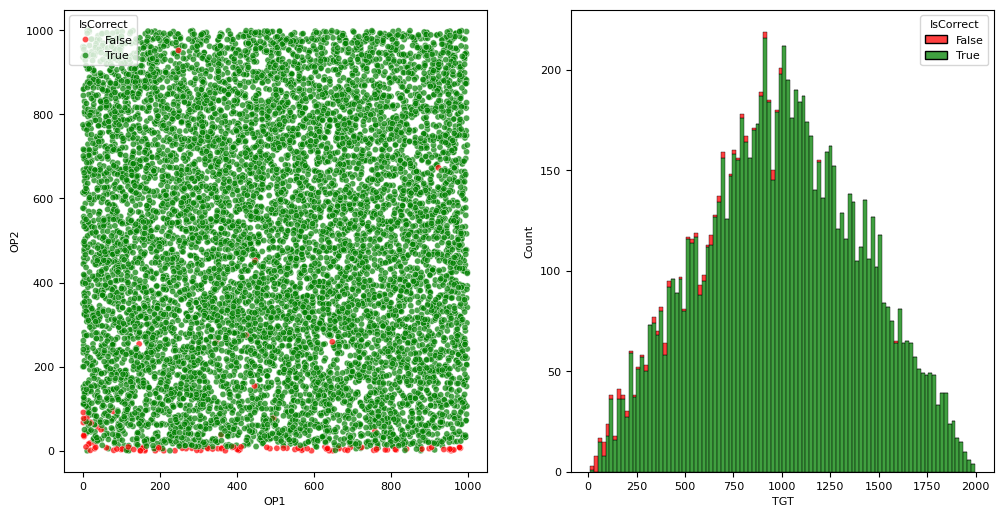

In [26]:
import pandas as pd
import seaborn as sns


op1, op2, tgt, ans = [], [], [], []
for sample, pred in zip(data_test, num_ans_test):    
    op1.append(int(sample[0].split('+')[0]))
    op2.append(int(sample[0].split('+')[1].replace('=', '')))
    tgt.append(int(sample[1]))
    ans.append(int(pred.item()))
df_test = pd.DataFrame(data={'OP1': op1, 'OP2': op2, 'TGT': tgt, 'ANS': ans})
df_test['IsCorrect'] = df_test['TGT'] == df_test['ANS']

op1, op2, tgt, ans = [], [], [], []
for sample in data_train:    
    op1.append(int(sample[0].split('+')[0]))
    op2.append(int(sample[0].split('+')[1].replace('=', '')))
    tgt.append(int(sample[1]))    
df_train = pd.DataFrame(data={'OP1': op1, 'OP2': op2, 'TGT': tgt})

# Scatter plot
palette = {True: "green", False: "red"}
fig, ax = plt.subplots(1,2, figsize=(2*6,6))
sns.scatterplot(data=df_test, x="OP1", y="OP2", hue="IsCorrect", alpha=0.7, s=20, ax=ax[0], palette = palette)
sns.histplot(data=df_test, x="TGT", hue="IsCorrect", multiple="stack", bins=100, ax=ax[1], palette = palette)

**Question:** What approaches would you take to address this issue in the model?